# Calculate and plot the number of exchanged messages over time

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Global variables

In [3]:
pd.set_option("display.precision", 10)
pd.set_option('display.max_rows', 500)

timeframe_upper_limit = 60 # Seconds after startup that you want to look at

In [4]:
paths =	{
  # "111": "../../logs/movement/25-03-2021",
  "73": "../../logs/movement/30-03-2021",
}

exclude_paths = [
  "movement_log_tuples_run_0",
  "movement_log_tuples_run_1",
  "movement_log_tuples_run_2"]


num_nodes = 73
height = 2
degree = 8

num_runs = {
  73:9,
  111: 5
}

In [5]:
# m_xxx = maintenance_xxx
# d_xxx = data_xxx
m_stamps = []
m_topologies = []
m_node_ids = []
m_runs = []
m_connect_outliers = []

d_stamps = []
d_topologies = []
d_node_ids = []
d_runs = []

startup_times = {}

for path in paths : 
    #print(path)
    for root, dirs, files in os.walk(paths[path]) :
        dirs[:] = [directory for directory in dirs if directory not in exclude_paths]
        run = root.split('_')[-1]
        
        for file in files :
            with open( os.path.join(root, file) ) as log :   
                connect_attempts = 0
                node_id = file.split('_')[0][4:]              
                for line in log :            
                    if "RECEIVED MESSAGE" in line:
                        # maintencance messages 
                        elem = line.split( )                
                        m_node_ids.append(int(node_id))                        
                        m_stamps.append( int(elem[8]) ) # unix timestamp
                        m_topologies.append( int(path) )
                        m_runs.append(int(run))
                    elif "DATA RECEIVED" in line:
                        # data messages
                        pass
                    elif "STARTUP TIME" in line:
                        elem = line.split( )
                        startup_times[int(run)] = int(elem[-1])
                    elif "Try to connect" in line:
                        connect_attempts += 1
                
                if (connect_attempts > 5):
                    m_connect_outliers.append("run " + run + " node " + node_id)

m_data = pd.DataFrame(np.column_stack([m_topologies, m_runs, m_node_ids, m_stamps]), columns=['topology', 'run', 'node_id', 'timestamp'])
# print(connect_attempts)
# m_data

In [6]:
m_data['timestamp'] = m_data.apply(lambda row: row.timestamp - startup_times[row.run], axis=1)
m_data['timestamp_sec'] = m_data['timestamp'].apply(lambda x: x // 1000000000)
m_data

,topology,run,node_id,timestamp,timestamp_sec
0,73,5,1,890301047,0
1,73,5,1,890465082,0
2,73,5,1,890500026,0
3,73,5,1,890512310,0
4,73,5,1,890973129,0
...,...,...,...,...,...
55487,73,0,19,51021018154,51
55488,73,0,19,51042956489,51
55489,73,0,19,51050867349,51
55490,73,0,19,56437797872,56


# Reduce timeframe

In [7]:
m_data = m_data[m_data.timestamp_sec <= timeframe_upper_limit]
# m_data

# Try to find outliers

In [8]:
print("Nodes with connection issues:")
m_connect_outliers

Nodes with connection issues:


['run 4 node 38', 'run 6 node 23', 'run 1 node 61']

In [9]:
m_outliers = m_data.groupby(['topology', 'run', 'node_id', 'timestamp_sec']).size().reset_index(name='number of messages').sort_values(by=['number of messages'], ascending=False, axis=0)
# m_outliers.head()

# Compute results

In [10]:
m_grouped = m_data.groupby(['topology', 'timestamp_sec']).size().reset_index(name='number of messages')
m_grouped['number of messages'] = m_grouped.apply(lambda row: row['number of messages'] / num_runs[row['topology']], axis=1)
m_grouped['number of messages per node'] = m_grouped.apply(lambda row: row['number of messages'] / row['topology'], axis=1)
# m_grouped

# Plot

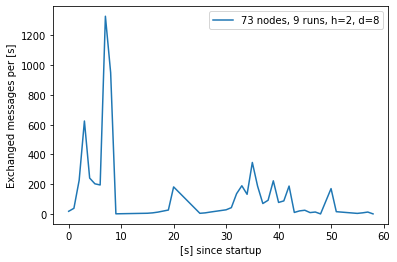

In [11]:
ax = plt.gca()

m_grouped.plot(kind='line',x='timestamp_sec',y='number of messages',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Exchanged messages per [s]")

plt.legend([str(num_nodes) +' nodes, ' + str(num_runs[num_nodes]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

stepsize=10
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))
plt.savefig('movement-paper-explore.pdf')  

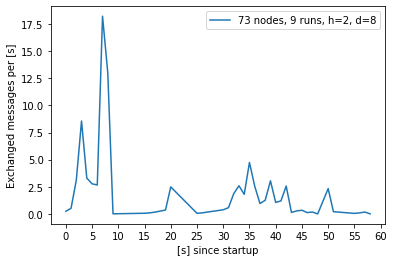

In [12]:
ax = plt.gca()

m_grouped.plot(kind='line',x='timestamp_sec',y='number of messages per node',ax=ax)

plt.xlabel("[s] since startup")
plt.ylabel("Exchanged messages per [s]")

plt.legend([str(num_nodes) +' nodes, ' + str(num_runs[num_nodes]) + ' runs, h=' + str(height) + ', d=' + str(degree)], loc=1)

stepsize=5
ax.xaxis.set_ticks(np.arange(0, timeframe_upper_limit + 1, stepsize))
plt.savefig('movement-avg-msgs-per-node-73.pdf')  

In [13]:
first_30 = m_grouped[m_grouped['timestamp_sec'] <= 30]['number of messages'].sum()
first_60 = m_grouped[m_grouped['timestamp_sec'] <= 60]['number of messages'].sum()

print('Overall exchanged maintenance messages within first 30s: ' + str(first_30))
print('Overall exchanged maintenance messages within first 60s: ' + str(first_60))

print('\nOverall exchanged maintenance messages during first 30s per node: ' + str(first_30 / 111))

Overall exchanged maintenance messages within first 30s: 4109.333333333333
Overall exchanged maintenance messages within first 60s: 6165.7777777777765

Overall exchanged maintenance messages during first 30s per node: 37.02102102102102


In [14]:
movement_messages = m_grouped[(m_grouped['timestamp_sec'] >= 31 ) & (m_grouped['timestamp_sec'] <= 41)]['number of messages'].sum()
print("Number of messages exchanges while the nodes move: " + str(movement_messages))
print("Number of messages exchanges per node while the nodes move: " + str(movement_messages/64))

Number of messages exchanges while the nodes move: 1582.3333333333335
Number of messages exchanges per node while the nodes move: 24.723958333333336
